In [6]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

## 1. Loading the individual parameters and raw data

In [1]:
path = 'simulated_study/'
output_folder = 'output_1/'

In [3]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

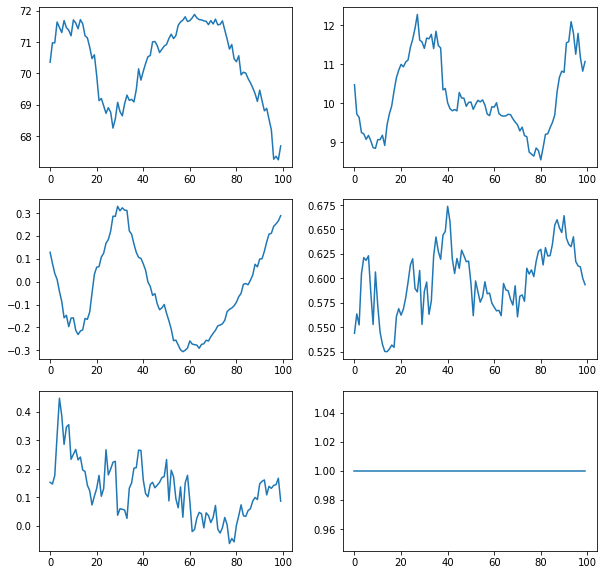

In [7]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [8]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([ 62.59649948,  72.69495126,  68.13860528,  65.72744611,
         73.68372648,  45.09352123,  75.64105321,  63.56004699,
         66.3817125 ,  66.47202216,  73.32065739,  74.33868609,
         59.92360746,  65.43072892,  72.22933622,  83.0860822 ,
         68.02523715,  74.62303225,  73.70554718,  91.72619058,
         70.85352523,  58.12076807,  67.32010606,  74.71077121,
         71.02180202,  75.88978857,  73.46717662,  80.74650139,
         76.0347742 ,  76.20798113,  70.68556353,  62.0846136 ,
         68.28574934,  70.54173963,  83.58509649,  63.48011542,
         70.69872007,  69.7747623 ,  70.93190501,  66.6935943 ,
         56.24339429,  63.99445577,  74.05701774,  76.09095639,
         79.06440227,  76.44994879,  74.37686522,  65.90822588,
         69.02850462,  60.3933798 ,  73.5770306 ,  59.02768338,
         49.66130514,  63.58397756,  57.04343801,  61.44475125,
         71.19780958,  74.38749991,  69.29274564,  78.15996278,
         72.03295453,  78.7

In [9]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=0)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=0)

ip

ValueError: Length of values (1) does not match length of index (100)

In [22]:
data = pd.DataFrame(index=[ids, times], columns=['adas_memory', 'hippocampus'])
data['adas_memory'] = adas_memory
data['hippocampus'] = hippocampus
data

adas_memory  hippocampus
4    74.868477     0.407333     0.377389
     75.075706     0.518444     0.375055
     75.282936     0.466667     0.364087
     75.490158     0.540667     0.382969
     76.111847     0.511111     0.429288
...                     ...          ...
1425 78.461342     0.540667     0.242699
     79.093491     0.607333     0.267690
1430 84.350166     0.577778     0.745385
     84.780472     0.659333     0.774981
     86.071396     0.770444     0.804698

[942 rows x 2 columns]

In [11]:
times = [time[0] for time in pd.read_csv(path+output_folder+'LongitudinalMetricModel_absolute_times.txt', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [12]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data

logistic  sum_logistic
0  80.555954   0.671867      0.709018
   81.127754   0.633226      0.821706
   81.699554   0.698169      0.845352
   82.271355   0.762729      0.888620
   82.843155   0.821946      0.825554
...                 ...           ...
99 98.043839   0.785172      1.052550
   98.682388   0.685539      0.940990
   99.320930   0.923546      0.898364
   99.959480   0.813647      0.982414
   100.598030  0.771752      1.027962

[500 rows x 2 columns]

In [13]:
individual_parameters = pd.read_csv(path+'/simulated_data_1/true_individual_parameters.csv').set_index('Unnamed: 0')
individual_parameters.index.name = 'ID'
individual_parameters

,xi,tau,source
ID,,,
0,0.350344,62.083605,9.135017
1,-0.133719,77.940924,-9.391076
2,-0.011949,62.703545,11.573273
3,0.495156,74.406601,-8.940739
4,0.752556,66.583951,-14.496141
...,...,...,...
95,-0.210039,65.561583,3.077332
96,1.278119,62.386677,0.699214
97,0.503653,71.914305,4.360673


In [5]:
tau = [tau[0] for tau in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_sources.txt', header=None).values]

individual_parameters_after_initialization = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
individual_parameters_after_initialization['tau'] = tau
individual_parameters_after_initialization['xi'] = xi
individual_parameters_after_initialization['source'] = sources

NameError: name 'individual_parameters' is not defined

In [14]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

estimated_ip = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
estimated_ip['tau'] = tau
estimated_ip['xi'] = xi
estimated_ip['source'] = sources

In [17]:
abs(individual_parameters - estimated_ip).describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,0.346972,5.472662,6.147815
std,0.251198,5.668429,4.331544
min,0.002579,0.144356,0.419914
25%,0.131610,1.723376,2.827234
50%,0.310233,3.724393,5.025700
75%,0.526227,7.796171,8.599099
max,1.306482,35.669528,19.225902


In [32]:
path = 'mds_study'
times = [time[0] for time in pd.read_csv(path+'/output/LongitudinalMetricModel_absolute_times.txt', header=None).values]
mds1 = [score[0] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
mds2 = [score[1] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [33]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data

mds1      mds2
3001 59.910362  0.500000  0.133333
     59.982315  0.571429  0.133333
     60.215916  0.500000  0.133333
     60.449516  0.500000  0.200000
     60.683113  0.571429  0.200000
...                  ...       ...
3467 71.582550  0.500000  0.733333
     71.708649  0.714286  0.800000
     71.957832  0.357143  0.733333
     72.333115  0.357143  0.666667
     72.708397  0.357143  0.733333

[3000 rows x 2 columns]

In [35]:
reconstructed = pd.read_csv('mds_study/personalize_output/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['mds1', 'mds2']
reconstructed.index = data.index

In [36]:
abs(reconstructed-data).describe()

,mds1,mds2
count,3000.000000,3000.000000
mean,0.163081,0.180404
std,0.134820,0.168752
min,0.000148,0.000094
25%,0.061791,0.060085
50%,0.131837,0.135601
75%,0.231493,0.250328
max,1.103094,2.036188


## 2. Evaluating the reconstruction error

In [18]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_pruned.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [19]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

INFO:__main__:Setting initial onset ages from simulated_study/personalize_pruned/LongitudinalMetricModel_onset_ages.txt file
INFO:__main__:Setting initial log accelerations from simulated_study/personalize_pruned/LongitudinalMetricModel_log_accelerations.txt file
INFO:__main__:Initializing exponential type to parametric
INFO:__main__:Loading metric parameters from file simulated_study/output_5_kernel_0.15/LongitudinalMetricModel_metric_parameters.txt
INFO:__main__:Loading the interpolation points from file simulated_study/output_5_kernel_0.15/LongitudinalMetricModel_interpolation_points.txt
INFO:__main__:The width for the metric interpolation is set to 0.15
INFO:__main__:I am setting the no_parallel_transport flag to False.
INFO:__main__:>> Reading 1-source initial modulation matrix from file: simulated_study/personalize_pruned/LongitudinalMetricModel_modulation_matrix.txt
INFO:__main__:Setting initial sources from simulated_study/personalize_pruned/LongitudinalMetricModel_sources.txt 

301 good iterations out of 303


INFO:deformetrica.core.models.longitudinal_metric_learning:Tmin 20.091094970703125 Tmax 95.60552215576172 Update of the spatiotemporalframe: 1471 ms


151 good iterations out of 152


INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:__main__:>> Initial noise variance set to 0.018114514965564012 based on the initial mean residual value.
INFO:deformetrica.core.models.longitudinal_metric_learning:>> The time shift variance prior degrees of freedom parameter is set to 100
INFO:deformetrica.core.models.longitudinal_metric_learning:>> The log-acceleration variance prior degrees of freedom parameter is set to the number of subjects: 100
INFO:deformetrica.core.models.longitudinal_metric_learning:('v0', False)
INFO:deformetrica.core.models.longitudinal_metric_learning:('p0', False)
INFO:deformetrica.core.models.longitudinal_metric_learning:('reference_time', False)
INFO:deformetrica.core.models.longitudinal_metric_learning:('onset_age_variance', False)
INFO:deformetrica.core.models.longitudinal_metric_learning:('log_acc

In [20]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

INFO:deformetrica.core.models.longitudinal_metric_learning:Acceleration factors max/min: (1.5279745, 68, 0.6456918, 92)


301 good iterations out of 303


INFO:deformetrica.core.models.longitudinal_metric_learning:Tmin 20.091094970703125 Tmax 95.60552215576172 Update of the spatiotemporalframe: 1160 ms


151 good iterations out of 152


In [21]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin


In [28]:
predicted = data.copy()
predicted['logistic'] = [prediction[0] for prediction in predictions]
predicted['sum_logistic'] = [prediction[1] for prediction in predictions]

In [29]:
diff = predicted - data
abs(diff).describe()

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.071123,0.077812
std,0.057143,0.061194
min,0.000148,0.000021
25%,0.027843,0.032657
50%,0.059121,0.064190
75%,0.099686,0.109468
max,0.425140,0.433377


In [30]:
predicted.describe()

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.519929,0.648205
std,0.144147,0.109638
min,0.197382,0.098206
25%,0.410102,0.609164
50%,0.520552,0.650964
75%,0.612343,0.711851
max,0.793787,0.889141


In [220]:
data.describe(percentiles=[.9])

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.510620,0.655286
std,0.189256,0.162464
min,0.084783,0.136826
50%,0.516825,0.654417
90%,0.756454,0.867518
max,0.974269,1.095116


## Geodesic visualization

In [43]:
study = 'bivariate_study/'
output_folder = 'output/'

geodesic = pd.read_csv(study+output_folder+'LongitudinalMetricModel_reference_geodesic_trajectory_values.txt', sep=' ', header=None)
source_pos = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_pos.txt', sep=' ', header=None)
source_neg = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_neg.txt', sep=' ', header=None)

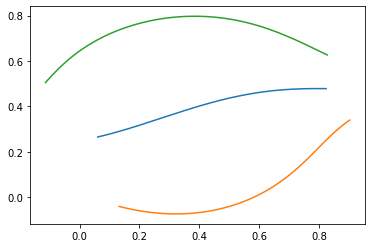

In [44]:
plt.plot(geodesic[0].values, geodesic[1].values)
plt.plot(source_pos[0].values, source_pos[1].values)
plt.plot(source_neg[0].values, source_neg[1].values)
plt.show()